# "Constrained" MaxCut

In this example we test the following idea: what if we had an oracle that would tell us how many nodes were on each side of an optimal cut for a given graph? In more technical terms, this is an oracle for the "optimal Hamming weight" of a given MaxCut instance. Could we use this information to speed-up QAOA?

We'll test this idea by comparing the performance of standard unconstrained QAOA (traditional initial [state](https://lanl.github.io/JuliQAOA.jl/dev/utils/#JuliQAOA.states-Tuple{Any}), [transverse field mixer](https://lanl.github.io/JuliQAOA.jl/dev/mixers/#JuliQAOA.mixer_x)) against a QAOA constrained to the "optimal" Hamming weight $k$ (starting with the [Dicke state](https://lanl.github.io/JuliQAOA.jl/dev/utils/#JuliQAOA.dicke_states-Tuple{Any,%20Any}) $|D^n_k\rangle$, [clique](https://lanl.github.io/JuliQAOA.jl/dev/mixers/#JuliQAOA.mixer_clique-Tuple{Int64,%20Int64}) and [ring](https://lanl.github.io/JuliQAOA.jl/dev/mixers/#JuliQAOA.mixer_ring-Tuple{Int64,%20Int64}) mixers).

This example touches on the following topics:

* constrained vs. unconstrained optimization
* global angle finding
* plotting

In [1]:
using JuliQAOA, Graphs
using Random
using Statistics

Random.seed!(1);

Let's start by solving this problem in the traditional way:

In [2]:
n = 6

g = erdos_renyi(n, 0.5)
obj_vals = [maxcut(g,x) for x in states(n)]

mixer = mixer_x(n)

# find good angles up to 8 rounds
p = 8
angles_x, evs_x = find_angles_bh(p, mixer, obj_vals);

done 1 rounds, exp. value = 5.30513
done 2 rounds, exp. value = 6.02756


done 3 rounds, exp. value = 6.26124


done 4 rounds, exp. value = 6.41244


done 5 rounds, exp. value = 6.55771


done 6 rounds, exp. value = 6.68819


done 7 rounds, exp. value = 6.75096


done 8 rounds, exp. value = 6.81351


Now let's find the Hamming weight(s) of the optimal states.

In [3]:
optimal_ks = []

for x in states(n)
    if maxcut(g, x) == maximum(obj_vals)
        push!(optimal_ks, sum(x))
    end
end
union!(optimal_ks)

1-element Vector{Any}:
 3

In this case all optimal states have Hamming weight 3. Let's now construct and test the constrained version of this problem.

As noted [here](https://lanl.github.io/JuliQAOA.jl/dev/angle_finding/), you can ignore the warnings that appear.

In [4]:
k = optimal_ks[1]
obj_vals_const = [maxcut(g,x) for x in dicke_states(n,k)]

mixer = mixer_clique(n,k)
println("finding clique angles")
angles_clique, evs_clique = find_angles_bh(p, mixer, obj_vals_const)

mixer = mixer_ring(n,k)
println("finding ring angles")
angles_ring, evs_ring = find_angles_bh(p, mixer, obj_vals_const);

finding clique angles


done 1 rounds, exp. value = 6.01183
done 2 rounds, exp. value = 6.8078


┌ Warning: Using fallback BLAS replacements, performance may be degraded
└ @ Enzyme.Compiler ~/.julia/packages/GPUCompiler/2mJjc/src/utils.jl:59
┌ Warning: Using fallback BLAS replacements, performance may be degraded
└ @ Enzyme.Compiler ~/.julia/packages/GPUCompiler/2mJjc/src/utils.jl:59


done 3 rounds, exp. value = 7.0


done 4 rounds, exp. value = 7.0


done 5 rounds, exp. value = 7.0


done 6 rounds, exp. value = 7.0


done 7 rounds, exp. value = 7.0


done 8 rounds, exp. value = 7.0
finding ring angles
done 1 rounds, exp. value = 6.3551


done 2 rounds, exp. value = 6.73238


done 3 rounds, exp. value = 6.79676


done 4 rounds, exp. value = 6.88318


done 5 rounds, exp. value = 6.95504


done 6 rounds, exp. value = 6.995


done 7 rounds, exp. value = 6.99845


done 8 rounds, exp. value = 6.99993


Plot the output:

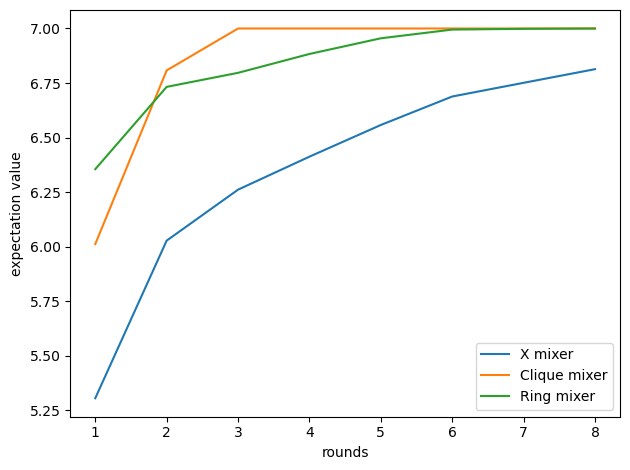

In [5]:
using PyPlot

fig, ax = subplots()

x = 1:p
y = evs_x
ax.plot(x, y, label="X mixer")

y = evs_clique
ax.plot(x, y, label="Clique mixer")

y = evs_ring
ax.plot(x, y, label="Ring mixer")

ax.set_xlabel("rounds")
ax.set_ylabel("expectation value")
ax.legend()

fig.tight_layout()
gcf()


That looks like a nice improvement on this graph, but we should probably run the same analysis over a few more graphs and average the performance. This might take a few minutes to run.

In [6]:
vals_x = []
vals_clique = []
vals_ring = []

num_samples = 10

for i in 1:num_samples
    println("testing graph #$i")
    g = erdos_renyi(n, 0.5)
    obj_vals = [maxcut(g,x) for x in states(n)]

    mixer = mixer_x(n)

    _, scores_x = find_angles_bh(p, mixer, obj_vals; verbose=false)

    # in the case of degenerate ground states with different k values, take the first one
    k = union(sum.(filter(x->maxcut(g,x)==maximum(obj_vals), collect(states(n)))))[1]

    obj_vals_const = [maxcut(g,x) for x in dicke_states(n,k)]

    mixer = mixer_clique(n,k)
    _, scores_clique = find_angles_bh(p, mixer, obj_vals_const; verbose=false)

    mixer = mixer_ring(n,k)
    _, scores_ring = find_angles_bh(p, mixer, obj_vals_const; verbose=false)

    # let's add the approximation ratio that each QAOA begins at
    prepend!(scores_x, mean(obj_vals))
    prepend!(scores_clique, mean(obj_vals_const))
    prepend!(scores_ring, mean(obj_vals_const))

    # convert to approximation ratio so that each graph contributes equally to the mean
    push!(vals_x, scores_x/maximum(obj_vals))
    push!(vals_clique, scores_clique/maximum(obj_vals))
    push!(vals_ring, scores_ring/maximum(obj_vals))
end

testing graph #1


testing graph #2


testing graph #3


testing graph #4


testing graph #5


testing graph #6


testing graph #7


testing graph #8


testing graph #9


testing graph #10


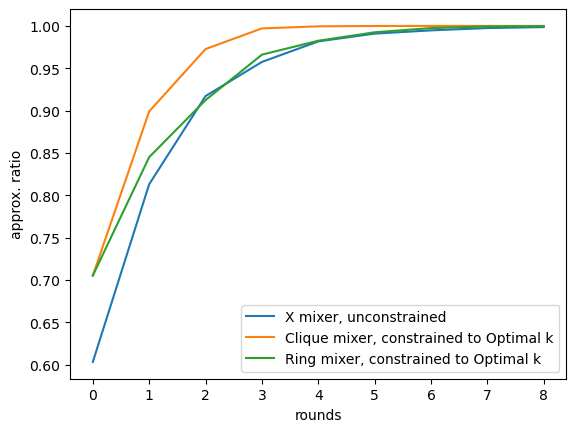

In [11]:
fig, ax = subplots()

x = 0:p
# average the round-by-round performance over each instance
y = [mean([vals_x[i][j] for i in 1:num_samples]) for j in 1:p+1]
ax.plot(x, y, label="X mixer, unconstrained")

y = [mean([vals_clique[i][j] for i in 1:num_samples]) for j in 1:p+1]
ax.plot(x, y, label="Clique mixer, constrained to Optimal k")

y = [mean([vals_ring[i][j] for i in 1:num_samples]) for j in 1:p+1]
ax.plot(x, y, label="Ring mixer, constrained to Optimal k")

ax.set_xlabel("rounds")
ax.set_ylabel("approx. ratio")
ax.legend()
gcf()

Looks like the clique mixer is the clear winner, with ring and X performing pretty similarly. 

Next step: re-run this experiment at higher `n` to see if the relative performance stays the same, gets better, or gets worse!